# Sharpe Optimised pairs trading - Eucledian Distance

# Import Data and Dependancies

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)

In [68]:
prices = pd.read_csv('spy_top200_021221.csv', index_col=0)

prices = prices.loc['2017-01-01':'2019-12-31'].dropna(axis=1)
prices.drop(['SPY'], axis=1, inplace=True)
prices

returns = prices.pct_change().dropna()
returns_train = returns.loc[:'2019-06-30']
returns_test = returns.loc['2019-07-01':]
prices_train = prices.loc[returns_train.index]
prices_test = prices.loc[returns_test.index]

# if (len(returns_train.index) % 2) == 0:
#   print(len(returns_train.index))
# else:
#   # length of training period must be even
#   prices_train = prices_train.iloc[1:]
#   returns_train = returns_train.iloc[1:]
#   print('index was an odd number so we removed a data point')
#   print(len(prices_train))

# Calculate_metrics / parse_pair / transform prices / in-sample Sharpe


In [69]:
# FUNCTIONS ####################################################################
pairs_dfs = {}
pair_rets = {}
traded_pairs = {}
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])

def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [70]:
from itertools import combinations

# transform prices to cumulative returns
cumret = (1 + returns).cumprod()
cumret = cumret / cumret.iloc[0]
cumret_train = cumret.loc[returns_train.index]
cumret_test = cumret.loc[returns_test.index]

stocks = cumret.columns
pairs = list(combinations(stocks, 2))
pairs_df = pd.DataFrame(columns=['Spread SSD', 'Spread SD'])

for s1, s2 in tqdm(pairs):
  spread = cumret_train[s1] - cumret_train[s2]
  ssd = np.sum(spread**2) / len(spread)
  sd = spread.std()
  pairs_df = pd.concat([pairs_df, pd.DataFrame([[ssd, sd]], columns=['Spread SSD', 'Spread SD'], index=[f'{s1}-{s2}'])])

pairs_df.sort_values(by='Spread SSD')

100%|██████████| 19110/19110 [00:32<00:00, 594.69it/s]


,Spread SSD,Spread SD
GOOGL-GOOG,0.000505,0.011025
JPM-BAC,0.001651,0.039040
CB-CL,0.001694,0.040817
SPGI-MCO,0.001837,0.041103
AXP-FIS,0.002366,0.047803
...,...,...
ALGN-DD,3.078595,0.919079
T-ALGN,3.121136,0.875578
AIG-ALGN,3.188956,0.885065
ALGN-SLB,3.561085,0.896531


In [71]:
# calculate in-sample Sharpe ratios for top N pairs
N = 200
insample_sharpe = pd.DataFrame(index=pairs_df.sort_values(by='Spread SSD').index[:N], columns=['Sharpe'])

for pair in insample_sharpe.index:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = cumret_train[s1] - cumret_train[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=spread.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    for t in spread.index:
        if spread.loc[t] > 2*sd:
            short = True
            positions.loc[t] = [-1,1] # open short position
        elif spread.loc[t] < -2*sd:
            long = True
            positions.loc[t] = [1,-1] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    
    ret = (positions.shift() * returns_train[[s1,s2]]).sum(axis=1)
    insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)

<ipython-input-71-8e57632617a6>:35: RuntimeWarning: invalid value encountered in double_scalars
  insample_sharpe.loc[pair] = np.sqrt(252) * np.nanmean(ret) / np.nanstd(ret)


# Hyperparameter optimisation

In [72]:
best_sharpe = -10000
best_thresh = 0
best_max_DD = 100000000000
for thresh in range(15,25):
  for s in range(0,9):
    cond1 = insample_sharpe['Sharpe'] > 1+(float(s)/10)

    insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False)

    potential_pairs = insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False).index

    pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

    for pair in potential_pairs:
        s1,s2 = parse_pair(pair)
        
        # construct spread
        spread = cumret_test[s1] - cumret_test[s2]
        sd = pairs_df.loc[pair]['Spread SD'] # historical SD
        
        positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
        
        # indicators of long\short positions
        short = False
        long = False
        
        for t in spread.index:
            if spread.loc[t] > 0.1*thresh*sd:
                short = True
                positions.loc[t] = [-1,1] # open short position
            elif spread.loc[t] < -0.1*thresh*sd:
                long = True
                positions.loc[t] = [1,-1] # open long position
            elif short and spread.loc[t] < 0:
                short = False
                positions.loc[t] = [0,0] # close short position
            elif long and spread.loc[t] > 0:
                long = False
                positions.loc[t] = [0,0] # close long position
        positions.fillna(method='ffill', inplace=True)
        positions.fillna(0, inplace=True)
        
        ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
        
        pair_ret[pair] = ret

        # cumulative returns of individual pairs
    pair_cumret = (1 + pair_ret).cumprod()
    # pair_cumret

    # fraction of pairs with positive returns
    (pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

    # fraction of pairs with no positions
    (pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

    total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)
    total_cumret = (1 + total_ret).cumprod()
    results_df.loc['Simple Distance'] = calculate_metrics(total_cumret)

    if (best_sharpe < results_df['Sharpe'].values[0]):
      best_sharpe = results_df['Sharpe'].values[0]
      best_sharpe_filter = 1+(float(s)/10)
      best_thresh = 0.1*thresh

    # if (best_thresh < 0.1*thresh):
      

    if ((0.1*thresh == best_thresh) and (results_df['Sharpe'].values[0] == best_sharpe)):
      best_max_DD = results_df['MaxDD'].values[0]

    print('thresh',0.1*thresh,' |||  sharpe filter =', 1+(float(s)/10),':')
    print(results_df)
    print()
    print()
print('best_sharpe filter (',best_sharpe_filter,') gives portfolio validation sharpe of ',best_sharpe, ', Drawdown: ',best_max_DD,', best_thresh: ',best_thresh)





thresh 1.5  |||  sharpe filter = 1.0 :
                 Total return       APR    Sharpe     MaxDD  MaxDDD
Simple Distance      0.054128  0.109357  3.314025 -0.014051    23.0


thresh 1.5  |||  sharpe filter = 1.1 :
                 Total return       APR    Sharpe     MaxDD  MaxDDD
Simple Distance       0.05172  0.104374  3.001603 -0.014416    23.0


thresh 1.5  |||  sharpe filter = 1.2 :
                 Total return       APR    Sharpe     MaxDD  MaxDDD
Simple Distance      0.052721  0.106444  2.998367 -0.014176    23.0


thresh 1.5  |||  sharpe filter = 1.3 :
                 Total return       APR    Sharpe     MaxDD  MaxDDD
Simple Distance      0.060647  0.122904  3.403205 -0.013848    23.0


thresh 1.5  |||  sharpe filter = 1.4 :
                 Total return       APR   Sharpe     MaxDD  MaxDDD
Simple Distance      0.067685  0.137621  3.46208 -0.011198    23.0


thresh 1.5  |||  sharpe filter = 1.5 :
                 Total return       APR    Sharpe     MaxDD  MaxDDD
Simple Dis

# Volatility normalised, Sharpe ratio optimised Eucledian distance pairs trading

leverage = 17.97 : 1
best_thresh = 2.2
best_sharpe_filter = 1.6


Total return     2.354352
APR              9.834078
Sharpe           4.682447
MaxDD           -0.143451
MaxDDD          17.000000
Name: Euc Dist Pairs Trades, dtype: float64

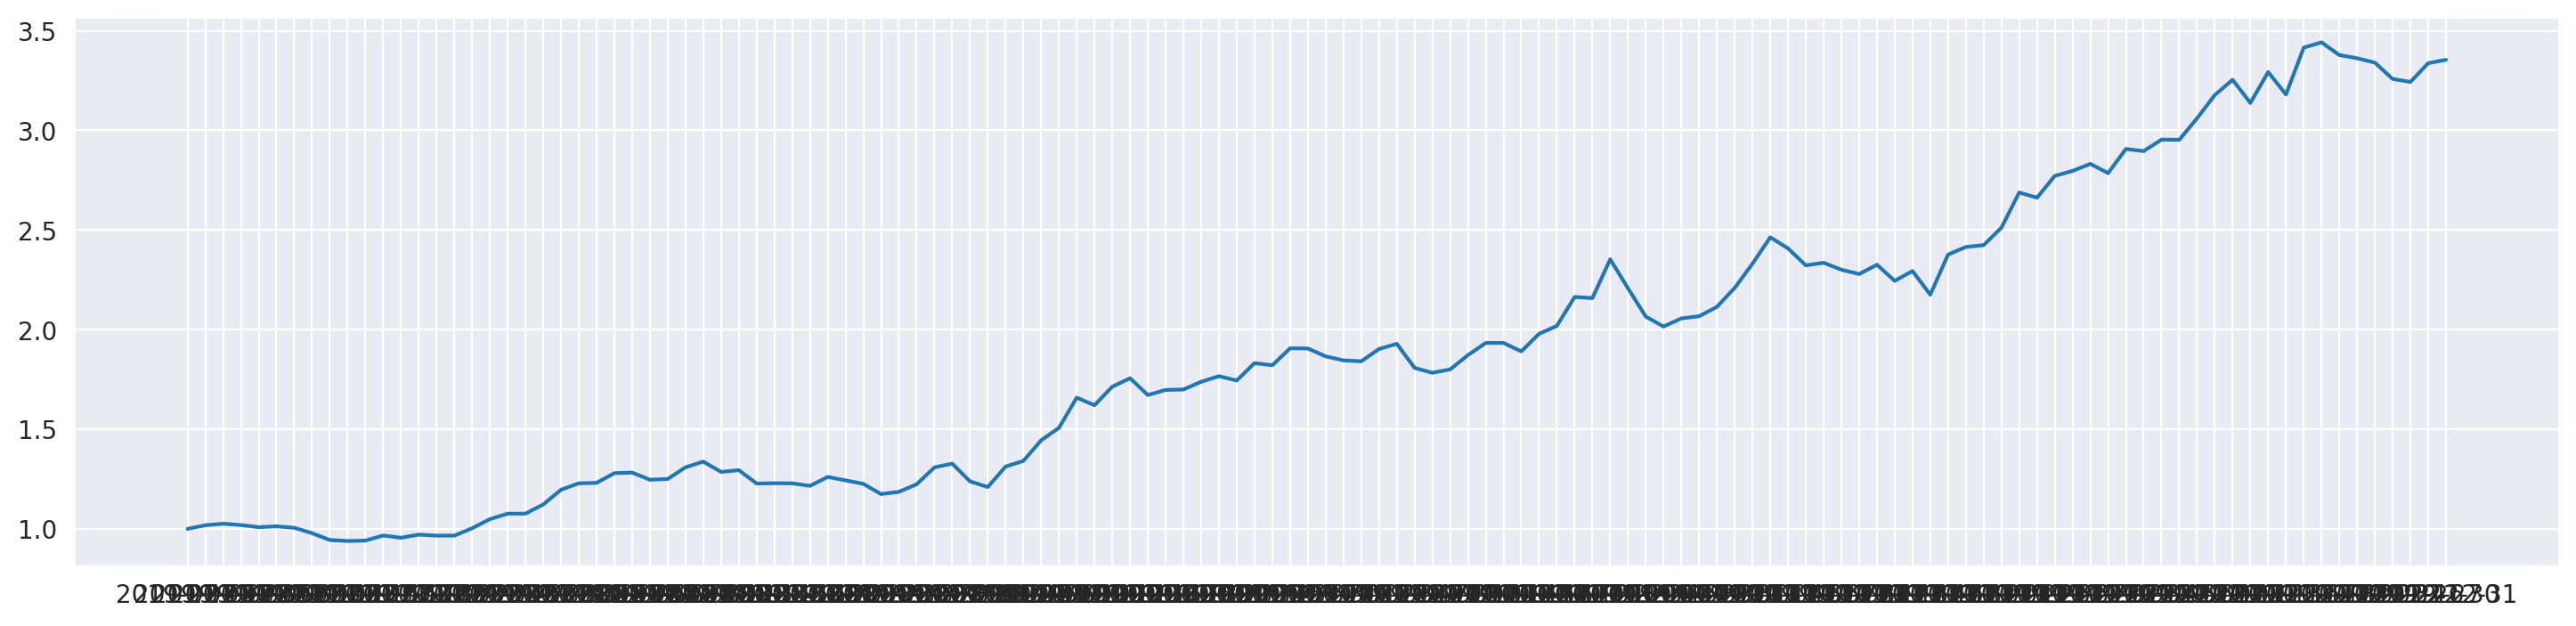

In [73]:
cond1 = insample_sharpe['Sharpe'] > best_sharpe_filter
insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False)
potential_pairs = insample_sharpe.loc[cond1].sort_values(by='Sharpe', ascending=False).index
pair_ret = pd.DataFrame(index=returns_test.index, columns=potential_pairs)

for pair in potential_pairs:
    s1,s2 = parse_pair(pair)
    
    # construct spread
    spread = cumret_test[s1] - cumret_test[s2]
    sd = pairs_df.loc[pair]['Spread SD'] # historical SD
    
    positions = pd.DataFrame(index=returns_test.index, columns=[s1,s2])
    
    # indicators of long\short positions
    short = False
    long = False
    
    max_allowed_DD = -0.15  # 15% drawdown volatility scaling
    max_leverage = 20       # 20:1 
    vol_scaled_trade = max_allowed_DD/best_max_DD
    if vol_scaled_trade > max_leverage:
      vol_scaled_trade = max_leverage

    for t in spread.index:
        if spread.loc[t] > best_thresh*sd:
            short = True
            positions.loc[t] = [-vol_scaled_trade,vol_scaled_trade] # open short position
        elif spread.loc[t] < -best_thresh*sd:
            long = True
            positions.loc[t] = [vol_scaled_trade,-vol_scaled_trade] # open long position
        elif short and spread.loc[t] < 0:
            short = False
            positions.loc[t] = [0,0] # close short position
        elif long and spread.loc[t] > 0:
            long = False
            positions.loc[t] = [0,0] # close long position
    positions.fillna(method='ffill', inplace=True)
    positions.fillna(0, inplace=True)
    ret = (positions.shift() * returns_test[[s1,s2]]).sum(axis=1)
    pair_ret[pair] = ret

# cumulative returns of individual pairs
pair_cumret = (1 + pair_ret).cumprod()

# fraction of pairs with positive returns
(pair_cumret.iloc[-1] > 1).sum() / pair_cumret.shape[1]

# fraction of pairs with no positions
(pair_cumret.iloc[-1] == 1).sum() / pair_cumret.shape[1]

total_ret = pair_ret.sum(axis=1) / len(pair_ret.columns)
total_cumret = (1 + total_ret).cumprod()

# plot cumulative return chart
plt.figure(figsize=(18,4))
plt.plot(total_cumret)

# display metrics
results_df.loc['Euc Dist Pairs Trades'] = calculate_metrics(total_cumret)
print('leverage =',round(vol_scaled_trade,2),': 1')
print('best_thresh =',best_thresh)
print('best_sharpe_filter =',best_sharpe_filter)
results_df.loc['Euc Dist Pairs Trades']

# References
modified from a [Medium](https://medium.com/@financialnoob/pairs-trading-with-wavelet-transform-2d94ff400abb) article by Alexander Pavlov